In [27]:
from autotrader import AutoData
import json
import requests
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import time 

#------------------------------------------------------------------------------------
#Download's price data and funding rate data for Mycelium Perp Swaps and Binance, has 
#about 45min run time.
#------------------------------------------------------------------------------------

'''Pulling Mycelium funding rate data to csv.'''
#pull historical funding rate and price data
myc_fr_response = requests.get("https://dev.api.tracer.finance/trs/fundingRates")
myc_fr_data = pd.DataFrame(myc_fr_response.json()['rows'])

#write funding rate data to csv
myc_fr_data.to_csv('raw_data/myc_fr.csv')

#------------------------------------------------------------------------------------
'''Calculate times for pulling rest of the mycelium price, binance perp funding rate and price data.'''

#get first and last funding rate data times, used for mycelium price data
start_unix_str = myc_fr_data['timestamp'].iloc[-1]
end_unix_str = myc_fr_data['timestamp'].iloc[0]

start_datetime = pd.to_datetime(start_unix_str, unit = 's').to_pydatetime()
end_datetime = pd.to_datetime(end_unix_str, unit = 's').to_pydatetime()

#------------------------------------------------------------------------------------
'''Pulling mycelium price data to csv.'''

#page size for price data
page_size = 20000

#get the number of data entries and first page of data
price_response = requests.get(f'https://dev.api.tracer.finance/trs/priceUpdates?from={start_unix_str}&to={end_unix_str}&page=1&pageSize={page_size}')
price_entries = price_response.json()['totalRecords'] # number of total price points recorded

myc_price = pd.DataFrame(price_response.json()['rows'])

#function used in threads to pull price data
def pull_myc_price(start_unix_str, end_unix_str, page_size, page_no):
    price_response = requests.get(f'https://dev.api.tracer.finance/trs/priceUpdates?from={start_unix_str}&to={end_unix_str}&page={page_no}&pageSize={page_size}')
    price_data = pd.DataFrame(price_response.json()['rows'])
    return(price_data)


#create threads
with ThreadPoolExecutor(max_workers=6) as executor:
    price_list=[]
    for i in range(2, (price_entries//page_size)+2):
        # submit job:
        price_list.append(executor.submit(
            pull_myc_price,
            start_unix_str = start_unix_str,
            end_unix_str = end_unix_str,
            page_size = page_size,
            page_no = i
        ))
        time.sleep(25)

#interpret results of threading   
for i,val in enumerate(price_list):
    result = val.result()
    #print(result)
    #price_data = pd.DataFrame(result.json()['rows'])
    myc_price = pd.concat([myc_price, result])
    #print(i)

#write price data to csv
myc_price.to_csv('raw_data/myc_price.csv')


#------------------------------------------------------------------------------------
'''Pulling binance perp funding rate and price data to csv.'''

#the following are the myc universe assets that have perps on binance, ETH = WETH, BTC = WBTC
binance_universe = ['ETH','BTC','LINK','UNI','FXS','BAL','CRV']

# perps on binance come with USDT or BUSD, so both will be used to compare
perp_quote = ['USDT', 'BUSD']

binance = AutoData(data_source ='ccxt', exchange = 'binanceusdm')
for quote in perp_quote:
    for ticker in binance_universe:
        #pull data into data frames
        try:
            fr_data = binance._ccxt_funding_history(f'{ticker}{quote}', start_time=start_datetime, end_time=end_datetime)
        except:
            continue
        try:
            price_data = binance.fetch(f'{ticker}{quote}', granularity='8h', start_time=start_datetime, end_time=end_datetime)
        except:
            continue
        
        #store data in csv's
        fr_data.to_csv(f'raw_data/binance_fr/{ticker}{quote}.csv')
        price_data.to_csv(f'raw_data/binance_price/{ticker}{quote}.csv')

#------------------------------------------------------------------------------------


1
2
3
4
5


"\n#the following are the myc universe assets that have perps on binance, ETH = WETH, BTC = WBTC\nbinance_universe = ['ETH','BTC','LINK','UNI','FXS','BAL','CRV']\n\n# perps on binance come with USDT or BUSD, so both will be used to compare\nperp_quote = ['USDT', 'BUSD']\n\nbinance = AutoData(data_source ='ccxt', exchange = 'binanceusdm')\nfor quote in perp_quote:\n    for ticker in binance_universe:\n        #pull data into data frames\n        try:\n            fr_data = binance._ccxt_funding_history(f'{ticker}{quote}', start_time=start_datetime, end_time=end_datetime)\n        except:\n            continue\n        try:\n            price_data = binance.fetch(f'{ticker}{quote}', granularity='8h', start_time=start_datetime, end_time=end_datetime)\n        except:\n            continue\n        \n        #store data in csv's\n        fr_data.to_csv(f'raw_data/binance_fr/{ticker}{quote}.csv')\n        price_data.to_csv(f'raw_data/binance_price/{ticker}{quote}.csv')\n\n#-----------------

In [317]:
import pandas as pd
pd.options.display.max_rows = 4000

#------------------------------------------------------------------------------------
#Clean's price data and funding rate data for Mycelium Perp Swaps to 8hr increments
#------------------------------------------------------------------------------------

''''Read Mycelium funding rate data from csv and put in formatable format'''
#read raw data from csv
myc_fr_raw = pd.read_csv('raw_data/myc_fr.csv', 
        usecols=['timestamp','symbol','endFundingRate','startFundingRate']
) 

#define funding rate columns
fr_symbols = myc_fr_raw.symbol
fr_timestamp = pd.to_datetime(myc_fr_raw['timestamp'], unit = 's')
fr = (myc_fr_raw.endFundingRate.astype(int) - myc_fr_data.startFundingRate.astype(int))/1000000

#create Mycelium Funding rate data frame
myc_fr = pd.DataFrame(
        data = {'timestamp':fr_timestamp,
                'symbol' : fr_symbols,
                'fr' :fr}).set_index('timestamp').iloc[::-1]

#last date in records
end = myc_fr.index[-1]

#truncation start date for all data
trunc_start = myc_fr.index[0]

''''Read Mycelium price data from csv and put in formatable format'''

#read raw data from csv 
myc_price_raw = pd.read_csv('raw_data/myc_price.csv',
                            usecols=['timestamp', 'symbol','price'])

#define funding rate columns
price_symbol = myc_price_raw.symbol
price_timestamp = pd.to_datetime(myc_price_raw['timestamp'], unit = 's')
        #numbers 27 digits are too large to calculate in pd.Dataframe
price = myc_price_raw['price'].str.removesuffix('000000000000000000000000000') # removes 27 zero's, divide 10^27
price = price.astype({'price':'int'})/1000

myc_price = pd.DataFrame(
        data = {'timestamp':price_timestamp,
                'symbol' : price_symbol,
                'price' : price}).set_index('timestamp').iloc[::-1]


'''Iterate through funding rate and price data filtering by token, reindexing to constant 
   frequecy datetime and populate missing data entries from reindexing'''

#create list to store data frames for each token
token_data = []
#mycelium universe
myc_universe = ['WETH','WBTC','LINK','UNI','USDC','USDT','DAI','FRAX','FXS','BAL','CRV']

#define truncation start date
for ticker in myc_universe:
        #create dataframe for each ticker
        fr_ = myc_fr[myc_fr.symbol == ticker]
        price_ = myc_price[myc_price.symbol == ticker]
        
        #set truncation start date
        fr_start_time = fr_.index[0]

        if fr_start_time > trunc_start:
                trunc_start = fr_start_time
        

        #remove duplicates from the price data
        price_ = price_[~price_.index.duplicated(keep='first')]
        
        #create indexes for reindexing
        hourly_index = pd.date_range(start= trunc_start, end= end, freq = 'h') # create index w/ const freq for comparison
        sec_index = pd.date_range(start= trunc_start, end=end, freq = 's') # create index to fill entries at the top of each hour, e.g. 
                                                                                # need data at 8:00:00 to reindex back to h

        #reindex data and populate timestamps with missings data
        fr_data = fr_.reindex(index = hourly_index, method = 'ffill')
        price_data = price_.reindex(index = sec_index, method = 'ffill')
        price_data = price_data.reindex(index = hourly_index)

        #create dataframe containing Funding Rate and price data for each token
        data_ = pd.DataFrame(index = hourly_index,
                             data = {'fr':fr_data['fr'],
                                     'price':price_data['price']})
        data_.index = data_.index.round('s')
        data_dict = {'token': f'{ticker}',
                    'myc_data': data_}

        token_data.append(data_dict)


'''find location of usdc in myc_universe'''
usdc_loc = myc_universe.index('USDC')

'''Read Binance data from csv and include in data_dict'''
#define quote tokens for perps on binance
perp_quote = ['USDT', 'BUSD']

#read binance data from csv and add to token_data
for i,data in enumerate(token_data):
        #convert tokens to wrapped versions for Binance perps
        if data['token'] == 'WBTC':
                ticker = 'BTC'
        elif data['token'] == 'WETH':
                ticker = 'ETH'
        else:
                ticker = data['token']

        #dict for storing binance perps data
        temp_dict = {}
        #read binance data from csv
        for quote in perp_quote:
                try:
                        bin_price = pd.read_csv(f'raw_data/binance_price/{ticker}{quote}.csv', parse_dates=['time'], index_col=['time'])
                        bin_fr = pd.read_csv(f'raw_data/binance_fr/{ticker}{quote}.csv', parse_dates= [0], index_col=[0])
                        bin_fr.index = bin_fr.index.round('s')
                except:
                        continue   
                myc_data_ = data['myc_data']
                data_frame = pd.DataFrame(index = bin_price.index,
                                         data = {#'binance_price':bin_price.Close,
                                                 'binance_fr':bin_fr.rate,
                                                 #'myc_price':myc_data_.price,
                                                 'myc_fr':myc_data_.fr,
                                                 'myc_usdc_fr':token_data[usdc_loc]['myc_data']['fr']})
                
                #data_frame = data_frame[~data_frame['myc_price'].isna()]
                #data_frame = data_frame[~data_frame['myc_fr'].isna()]
                #data_frame['price_dif'] = (data_frame['binance_price']-data_frame['myc_price'])/data_frame['myc_price']
                temp_dict[f'{quote}']=data_frame

        #if there one or more perps for this token then it will store them in token_data
        if len(temp_dict) > 0:
                token_data[i]['binance_data'] = temp_dict
        
'''Run data through formula (1) to determine:
        a. number of times there is a positive PnL
        b. total PnL
        c. determine the avg funding rate'''

#define test universe, universe of assets that have perps on binance
test_universe = ['WETH','WBTC','LINK','UNI','BAL','CRV']

#define fees, these are both taker fees to be conservative
binance_fees = {'USDT':0.0004,
                'BUSD':0.0003}

#create lists for average funding rates
index_list =[]
myc_avg_list=[]
binance_avg_list=[]
#iterate through token_data list with all the data in it
for i,data in enumerate(token_data):
        #only go do tokens with perps, that is tokens in test_universe
        if test_universe.count(data['token']) == 0:
                continue
        
        index_list.append(data['token'])
        myc_avg_list.append(data['myc_data']['fr'].mean()*8)

        stable_avg = []
        stable_avg.append(token_data[usdc_loc]['myc_data']['fr'].mean()*8)

        #iterate for both BUSD and USDT perps
        for stable,df in data['binance_data'].items():
                #print(data['token'])
                #define trading fee's
                binance_fee = binance_fees[stable]
                myc_fee = 0.0018
                fee = (2*binance_fee + myc_fee)
                #print(fee)

                pos_fr = df[df['binance_fr']>0]
                neg_fr = df[df['binance_fr']<0]

                pos_fr_pnl = (abs(pos_fr.binance_fr) - pos_fr.myc_fr - fee)/2
                neg_fr_pnl = (abs(neg_fr.binance_fr) - neg_fr.myc_usdc_fr - fee)/2

                fr_pnl = pd.concat([pos_fr_pnl,neg_fr_pnl])
                token_data[i]['binance_data'][stable]['fr_pnl'] = fr_pnl
                
                if stable == 'USDT':
                        binance_avg_list.append(df['binance_fr'].mean())
                #print('#########################################################################################')
                #print(data['token'],stable)
                #print(df['binance_fr'].mean())
                #print(token_data[i]['binance_data'][stable].to_markdown())

        fr_avg = data['myc_data']

''' Calculate the difference is average funding rate paid'''

#define the dataframe with avg funding rates paid
avg_df = pd.DataFrame(index = index_list,data = {'Binance (USDT)':binance_avg_list,
                                                'MPS Long':myc_avg_list,
                                                'MPS (USDC) Short':stable_avg})

#add column that has the differences in funding rates paid
bin_long = avg_df['Binance (USDT)'][avg_df['Binance (USDT)']>0]-avg_df['MPS (USDC) Short'][avg_df['Binance (USDT)']>0]
bin_short = abs(avg_df['Binance (USDT)'][avg_df['Binance (USDT)']<0])-avg_df['MPS Long'][avg_df['Binance (USDT)']<0]
fr_avg_pnl = pd.concat([bin_long,bin_short])
avg_df['Average PnL'] = fr_avg_pnl
#------------------------------------------------------------------------------------
### END OF PRODUCTION ###
#------------------------------------------------------------------------------------

In [343]:
''' "Short Term Opportunity" test'''

test_universe = ['WETH','WBTC','LINK','UNI','BAL','CRV']
count = 0
total_trades = 0
pnl_sum = 0

for i,data in enumerate(token_data):
        #only go do tokens with perps, that is tokens in test_universe
        if test_universe.count(data['token']) == 0:
            continue
        #iterate for both BUSD and USDT perps
        for stable,df in data['binance_data'].items():
            total_trades += len(df)
            pnl_sum += df['fr_pnl'].sum()
            pos_pnl = df[df['fr_pnl'] > 0]
            count += len(pos_pnl)
            if len(pos_pnl) > 0:
                print('_________________________________ P =',data['token']+stable,'_________________________________')
                print(pos_pnl.to_markdown())
                print('-------------------------------------------------------------------------------')
            #print(data['token'],stable)
            #print(df['binance_fr'].mean())
            #print(token_data[i]['binance_data'][stable].to_markdown()
avg_pnl = pnl_sum/total_trades
print('Summary:')
print(f'                    Positive PnL trades: {count}')
print(f'                  Total possible trades: {total_trades}')
print(f'         Average PnL per possible trade: {avg_pnl}')

_________________________________ P = BALUSDT _________________________________
| time                |   binance_fr |   myc_fr |   myc_usdc_fr |      fr_pnl |
|:--------------------|-------------:|---------:|--------------:|------------:|
| 2022-10-19 16:00:00 |  -0.00313345 |        0 |         2e-06 | 0.000265725 |
-------------------------------------------------------------------------------
Summary:
                    Positive PnL trades: 1
                  Total possible trades: 1230
         Average PnL per possible trade: -0.0012012586626016263


In [323]:
'''Print the average funding rates paid over the time duration '''
print('                    Average Funding Rate Paid from t_0 to t_1')
print(avg_df.to_markdown())

                    Average Funding Rate Paid from t_0 to t_1
|      |   Binance (USDT) |    MPS Long |   MPS (USDC) Short |   Average PnL |
|:-----|-----------------:|------------:|-------------------:|--------------:|
| WETH |      9.11081e-06 | 3.38939e-05 |         4.7454e-05 |  -3.83432e-05 |
| WBTC |      2.71697e-05 | 6.69725e-05 |         4.7454e-05 |  -2.02844e-05 |
| LINK |      5.0206e-05  | 0.00019837  |         4.7454e-05 |   2.75199e-06 |
| UNI  |      5.56424e-05 | 2.3128e-06  |         4.7454e-05 |   8.18833e-06 |
| BAL  |     -0.000232386 | 4.36267e-05 |         4.7454e-05 |   0.000188759 |
| CRV  |     -4.05061e-05 | 2.48152e-05 |         4.7454e-05 |   1.56909e-05 |


|      |   Days Held |
|:-----|------------:|
| BAL  |          17 |
| CRV  |         202 |
| LINK |         618 |
| UNI  |         208 |


/var/folders/63/hw4gzmdj3yx2vpgwk_2m12fw0000gn/T/ipykernel_64078/676114695.py:23: RuntimeWarning: invalid value encountered in divide
  bal_crv_fee =( x_cb/x_cb * fees['CRV,BAL']+trading_fee )*100
/var/folders/63/hw4gzmdj3yx2vpgwk_2m12fw0000gn/T/ipykernel_64078/676114695.py:33: RuntimeWarning: invalid value encountered in divide
  link_uni_fee = (x_lu/x_lu * fees['LINK,UNI']+trading_fee )*100


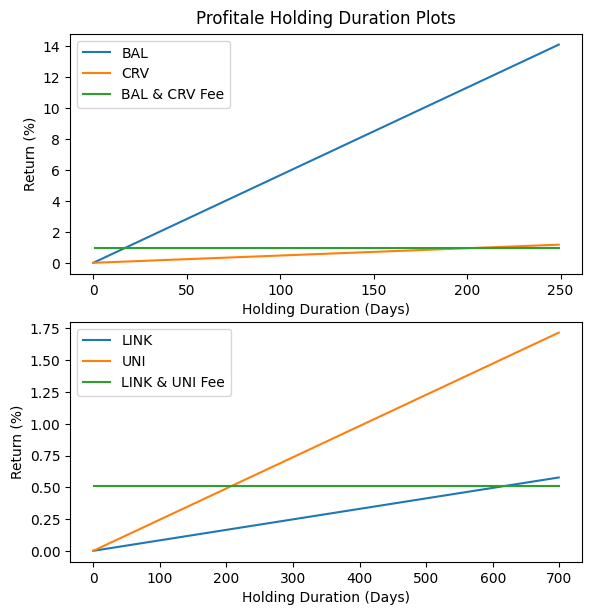

In [428]:
import matplotlib.pyplot as plt
import numpy as np
cb_days = 250
lu_days = 700
trading_fee = (0.0018 - 0.0004)/2

#spread fee on https://swaps.docs.mycelium.xyz/protocol-design/trading/fees#borrowing-fees
fees = {'LINK,UNI':0.0044,
        'CRV,BAL':0.0088}

prof_days = {}
annual_pnl = {}
#tokens and there proftiable PnL
prof_pnl = avg_df['Average PnL'][avg_df['Average PnL']>0]

x_cb = np.arange(0, cb_days,1)
x_lu = np.arange(0, lu_days,1)

fig,axs = plt.subplots(2)
#axs[0] = BAL and CRV
#axs[1] = LINK and UNI


bal_crv_fee =( x_cb/x_cb * fees['CRV,BAL']+trading_fee )*100
for token in ['BAL','CRV']:
    x = x_cb
    prof = prof_pnl.loc[token]
    y = prof * x * 3 *100
    annual_pnl[token] = prof * 3 * 100 * 365
    prof_days[token] = (np.where(y>bal_crv_fee))[0][0]
    axs[0].plot(x,y,label = token)
axs[0].plot(x_cb,bal_crv_fee,label = 'BAL & CRV Fee')


link_uni_fee = (x_lu/x_lu * fees['LINK,UNI']+trading_fee )*100
for token in ['LINK','UNI']:
    x = x_lu
    prof = prof_pnl.loc[token]
    y = prof * x * 3 *100
    annual_pnl[token] = prof * 3 * 100 * 365
    prof_days[token] = (np.where(y>link_uni_fee))[0][0]
    axs[1].plot(x,y,label = token)
axs[1].plot(x_lu,link_uni_fee,label = 'LINK & UNI Fee')




plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.2)

fig.suptitle('Profitale Holding Duration Plots', y= 1.25)

axs[0].set(xlabel='Holding Duration (Days)', ylabel='Return (%)')
axs[0].legend()

axs[1].set(xlabel='Holding Duration (Days)', ylabel='Return (%)')
axs[1].legend()

df_prof = pd.DataFrame(index = list(prof_days.keys()), data = {'Days Held for Profit':list(prof_days.values()),
                                                               'Annualized PnL':list(annual_pnl.values())})
print(df_prof.to_markdown())

plt.show()



In [382]:
print(prof_pnl)
print(prof_pnl.loc['LINK'])

LINK    0.000003
UNI     0.000008
BAL     0.000189
CRV     0.000016
Name: Average PnL, dtype: float64
2.7519878241436584e-06
